# 첫 번째 Feature Engineering 
그래프를 이용한 Feature Selection

- 하루간 평균 MET
- 하루간 활동 칼로리
- 하루간 총 사용 칼로리
- 비활동 시간
- 비활동 알람 횟수
- 저강도 활동 시간
- 하루간 비활동 MET
- 하루간 저강도 활동 MET
- 활동 점수
- 활동 목표달성 점수
- 회복시간 점수
- 활동 유지 점수
- 운동량 점수
- 매일 걸음 수
- 활동 총 시간(분)

In [25]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', None)

# 윈도우 기준 예시 (맑은 고딕)
rc('font', family='Malgun Gothic')
def init():
    walk_target = pd.read_csv('LifeLog\Data\\1.Training\라벨링데이터\\1.걸음걸이\\training_label.csv').rename(columns={'SAMPLE_EMAIL':"EMAIL"})
    walk_lifelog = pd.read_csv('LifeLog\Data\\1.Training\원천데이터\\1.걸음걸이\\train_activity.csv')
    walk_df = walk_lifelog.merge(walk_target,on='EMAIL')
    walk_df.rename(columns={
        'activity_average_met': '하루간 평균 MET',
        'activity_cal_active': '하루간 활동 칼로리',
        'activity_cal_total': '하루간 총 사용 칼로리',
        'activity_class_5min': '하루간 5분당 활동 로그',
        'activity_daily_movement': '매일 움직인 거리',
        'activity_day_end': '활동 종료 시간',
        'activity_day_start': '활동 시작 시간',
        'activity_high': '고강도 활동 시간',
        'activity_inactive': '비활동 시간',
        'activity_inactivity_alerts': '비활동 알람 횟수',
        'active_low': '저강도 활동 시간',
        'activity_medium': '중강도 활동 시간',
        'activity_met_1min': '하루간 1분 당 MET 로그',
        'activity_met_min_high': '하루간 고강도 활동 MET',
        'activity_met_min_inactive': '하루간 비활동 MET',
        'activity_met_min_low': '하루간 저강도 활동 MET',
        'activity_met_min_medium': '하루간 중강도 활동 MET',
        'activity_non_wear': '미착용 시간',
        'activity_rest': '휴식 시간',
        'activity_score': '활동 점수',
        'activity_low':'저강도 활동 시간',
        'activity_score_meet_daily_targets': '활동 목표달성 점수',
        'activity_score_move_every_hour': '매 시간 당 활동유지 점수',
        'activity_score_recovery_time': '회복시간 점수',
        'activity_score_stay_active': '활동 유지 점수',
        'activity_score_training_frequency': '운동 빈도 점수',
        'activity_score_training_volume': '운동량 점수',
        'activity_steps': '매일 걸음 수',
        'activity_total': '활동 총 시간(분)',
        'CONVERT(activity_class_5min USING utf8)': '하루간 5분당 활동 로그 (UTF-8)',
        'CONVERT(activity_met_1min USING utf8)': '하루간 1분당 MET 로그 (UTF-8)',
        'EMAIL': '이메일',
        'DIAG_NM': '진단명'
    }, inplace=True)
    return walk_df

selected_columns = ['하루간 평균 MET','하루간 활동 칼로리','하루간 총 사용 칼로리','비활동 시간','비활동 알람 횟수','저강도 활동 시간','하루간 비활동 MET',
                    '하루간 저강도 활동 MET','활동 점수','활동 목표달성 점수','회복시간 점수','활동 유지 점수','운동량 점수','매일 걸음 수','활동 총 시간(분)','진단명']

def feature_selection(df, columns:list):
    return df[columns]

def separate(df):
    X = df.drop(columns='진단명')
    y = df[['진단명']]
    return train_test_split(X,y,test_size=0.2,stratify=y)

def train_and_evaluate(model, X_train, y_train, X_test, y_test, scale=False):
    if scale:
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])
        pipeline.fit(X_train, y_train)
        train_score = pipeline.score(X_train, y_train)
        test_score = pipeline.score(X_test, y_test)
        feature_importances = None
    else:
        model.fit(X_train, y_train)
        train_score = model.score(X_train, y_train)
        test_score = model.score(X_test, y_test)
        feature_importances = getattr(model, 'feature_importances_', None)
    print(f"Model: {model}")
    print(f"Train accuracy: {train_score:.4f}")
    print(f"Test accuracy: {test_score:.4f}")
    if feature_importances is not None:
        print("Feature importances:", feature_importances)
    print(f'feature_names: {X_train.columns.tolist()}')
    print()

    return {'feature_importances': feature_importances, 'train_score':train_score, 'test_score':test_score, 'feature_names': X_train.columns.tolist()}

def plot_feature_importances(feature_importances, feature_names, model_name):
    if feature_importances is None:
        print(f"{model_name}에는 feature_importances가 없습니다.")
        return
    
    indices = np.argsort(feature_importances)[::-1]  # 중요도 내림차순 정렬
    
    plt.figure(figsize=(8,4))
    plt.title(f"{model_name} Feature Importances")
    plt.bar(range(len(feature_importances)), feature_importances[indices], align='center')
    plt.xticks(range(len(feature_importances)), [feature_names[i] for i in indices], rotation=90)
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.show()

In [26]:
df = init()
selected_df = feature_selection(df, selected_columns)
X_train, X_test, y_train, y_test = separate(selected_df)
RF_result = train_and_evaluate(RandomForestClassifier(n_estimators=200), X_train, y_train, X_test,y_test)
GBC_result = train_and_evaluate(GradientBoostingClassifier(), X_train, y_train, X_test,y_test)
Ada_result = train_and_evaluate(AdaBoostClassifier(), X_train, y_train, X_test,y_test)
KNN_result = train_and_evaluate(KNeighborsClassifier(), X_train, y_train, X_test, y_test, scale=True)
SVC_result = train_and_evaluate(SVC(), X_train, y_train, X_test, y_test, scale=True)
DT_result = train_and_evaluate(DecisionTreeClassifier(), X_train, y_train, X_test, y_test)

Model: RandomForestClassifier(n_estimators=200)
Train accuracy: 1.0000
Test accuracy: 0.6620
Feature importances: [0.04431904 0.08786038 0.10224193 0.08622328 0.01663354 0.08618725
 0.06109379 0.08790223 0.06616342 0.03576357 0.02594018 0.06702994
 0.05772309 0.09431974 0.08059861]
feature_names: ['하루간 평균 MET', '하루간 활동 칼로리', '하루간 총 사용 칼로리', '비활동 시간', '비활동 알람 횟수', '저강도 활동 시간', '하루간 비활동 MET', '하루간 저강도 활동 MET', '활동 점수', '활동 목표달성 점수', '회복시간 점수', '활동 유지 점수', '운동량 점수', '매일 걸음 수', '활동 총 시간(분)']

Model: GradientBoostingClassifier()
Train accuracy: 0.6973
Test accuracy: 0.6533
Feature importances: [0.03007353 0.05630479 0.18779818 0.06177522 0.03592948 0.08171289
 0.06616183 0.06966155 0.04089763 0.07748883 0.02806966 0.07039008
 0.0785558  0.08437227 0.03080825]
feature_names: ['하루간 평균 MET', '하루간 활동 칼로리', '하루간 총 사용 칼로리', '비활동 시간', '비활동 알람 횟수', '저강도 활동 시간', '하루간 비활동 MET', '하루간 저강도 활동 MET', '활동 점수', '활동 목표달성 점수', '회복시간 점수', '활동 유지 점수', '운동량 점수', '매일 걸음 수', '활동 총 시간(분)']

Model: AdaBoostClassifie

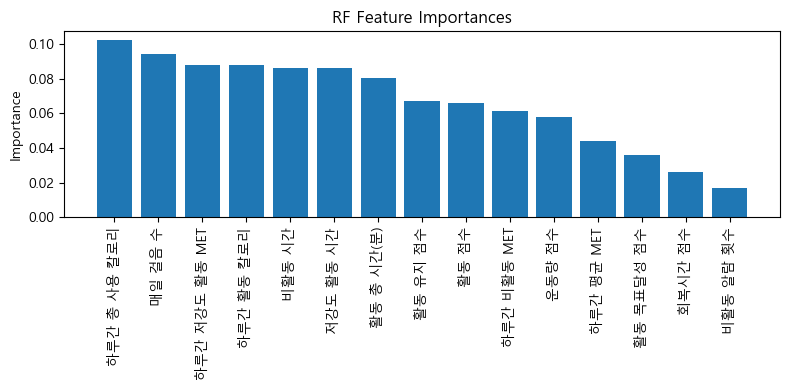

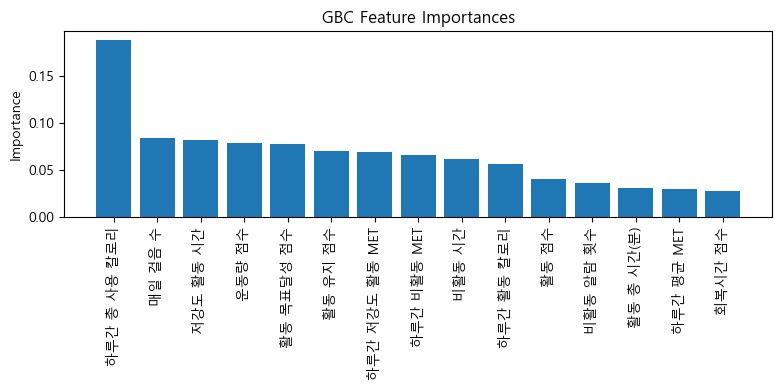

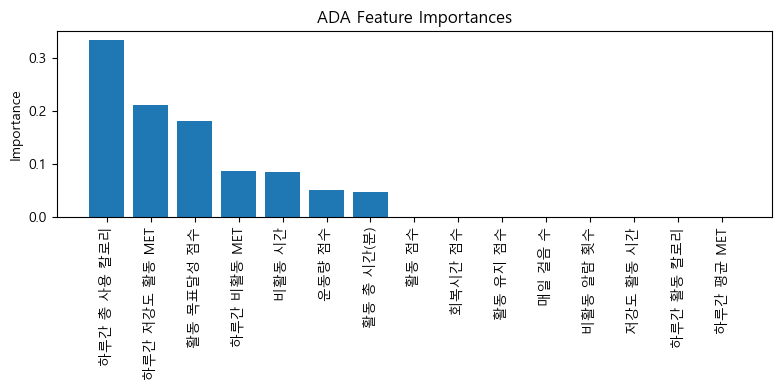

KNN에는 feature_importances가 없습니다.
SVC에는 feature_importances가 없습니다.


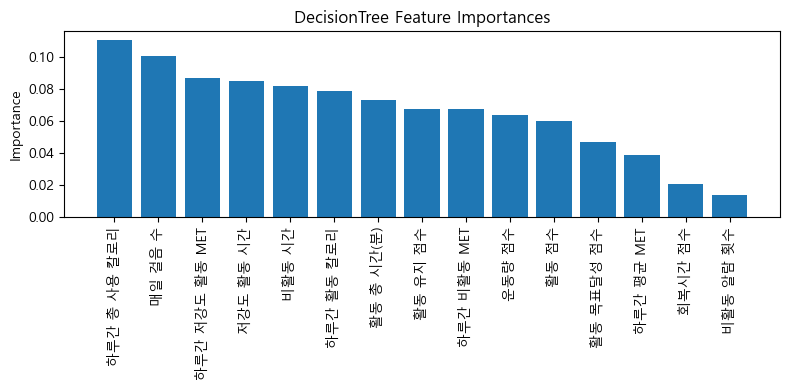

In [ ]:
plot_feature_importances(RF_result['feature_importances'], RF_result['feature_names'], 'RF')
plot_feature_importances(GBC_result['feature_importances'], GBC_result['feature_names'], 'GBC')
plot_feature_importances(Ada_result['feature_importances'], Ada_result['feature_names'], 'ADA')
plot_feature_importances(KNN_result['feature_importances'], KNN_result['feature_names'], 'KNN')
plot_feature_importances(SVC_result['feature_importances'], SVC_result['feature_names'], 'SVC')
plot_feature_importances(DT_result['feature_importances'], DT_result['feature_names'], 'DecisionTree')

# 다시 Reduction

Model: RandomForestClassifier(n_estimators=200)
Train accuracy: 1.0000
Test accuracy: 0.6502
Feature importances: [0.15730286 0.14213895 0.12740646 0.08516614 0.12998929 0.08697584
 0.14768983 0.12333064]
feature_names: ['하루간 총 사용 칼로리', '비활동 시간', '저강도 활동 시간', '하루간 비활동 MET', '하루간 저강도 활동 MET', '운동량 점수', '매일 걸음 수', '활동 총 시간(분)']

Model: GradientBoostingClassifier()
Train accuracy: 0.6807
Test accuracy: 0.6471
Feature importances: [0.26305094 0.14578085 0.11636241 0.07633232 0.09852421 0.12392861
 0.12323568 0.05278498]
feature_names: ['하루간 총 사용 칼로리', '비활동 시간', '저강도 활동 시간', '하루간 비활동 MET', '하루간 저강도 활동 MET', '운동량 점수', '매일 걸음 수', '활동 총 시간(분)']

Model: AdaBoostClassifier()
Train accuracy: 0.5984
Test accuracy: 0.5997
Feature importances: [0.30147446 0.0842466  0.08307249 0.09486848 0.22779372 0.10064348
 0.         0.10790077]
feature_names: ['하루간 총 사용 칼로리', '비활동 시간', '저강도 활동 시간', '하루간 비활동 MET', '하루간 저강도 활동 MET', '운동량 점수', '매일 걸음 수', '활동 총 시간(분)']

Model: KNeighborsClassifier()
Train accuracy:

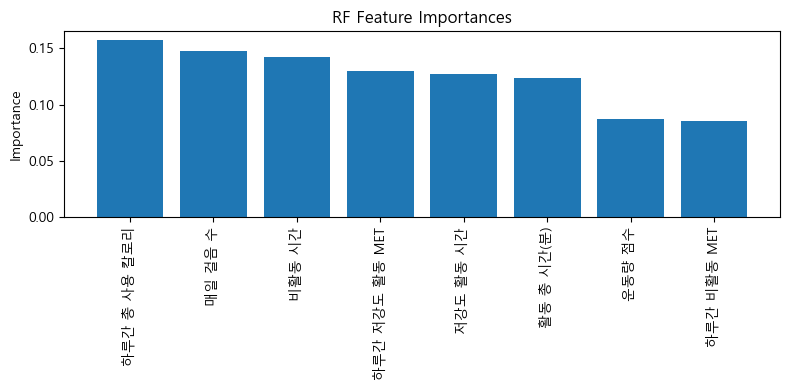

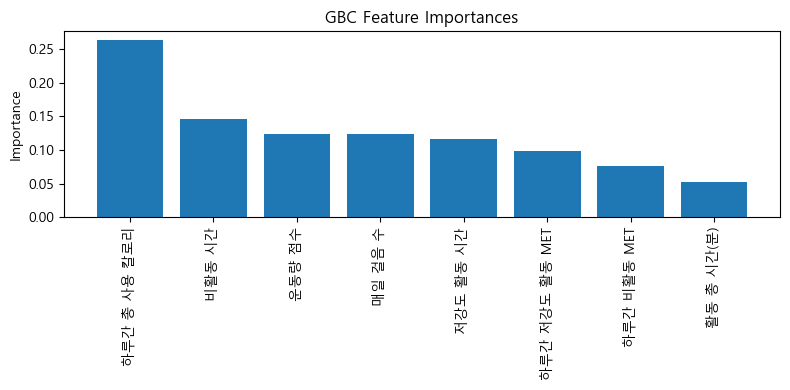

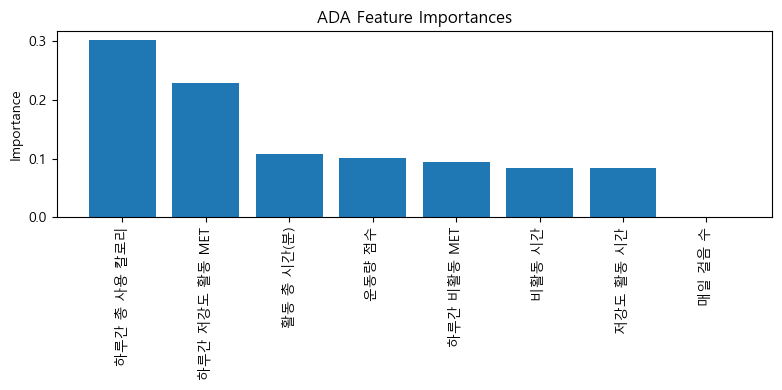

KNN에는 feature_importances가 없습니다.
SVC에는 feature_importances가 없습니다.


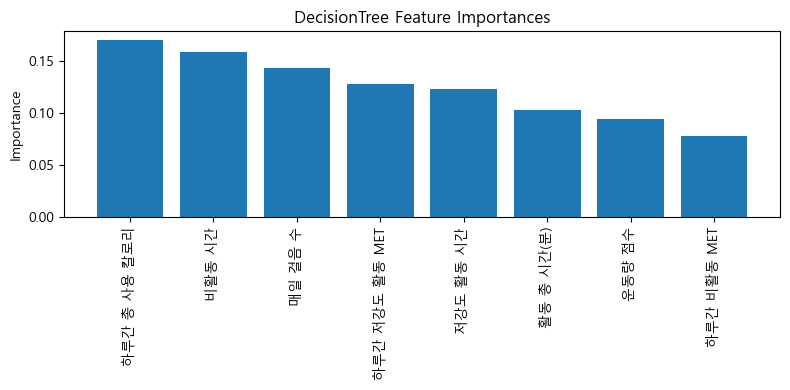

In [28]:
selected_columns = ['하루간 총 사용 칼로리','비활동 시간','저강도 활동 시간','하루간 비활동 MET',
                    '하루간 저강도 활동 MET','운동량 점수','매일 걸음 수','활동 총 시간(분)','진단명']
df = init()
selected_df = feature_selection(df, selected_columns)
X_train, X_test, y_train, y_test = separate(selected_df)
RF_result = train_and_evaluate(RandomForestClassifier(n_estimators=200), X_train, y_train, X_test,y_test)
GBC_result = train_and_evaluate(GradientBoostingClassifier(), X_train, y_train, X_test,y_test)
Ada_result = train_and_evaluate(AdaBoostClassifier(), X_train, y_train, X_test,y_test)
KNN_result = train_and_evaluate(KNeighborsClassifier(), X_train, y_train, X_test, y_test, scale=True)
SVC_result = train_and_evaluate(SVC(), X_train, y_train, X_test, y_test, scale=True)
DT_result = train_and_evaluate(DecisionTreeClassifier(), X_train, y_train, X_test, y_test)
plot_feature_importances(RF_result['feature_importances'], RF_result['feature_names'], 'RF')
plot_feature_importances(GBC_result['feature_importances'], GBC_result['feature_names'], 'GBC')
plot_feature_importances(Ada_result['feature_importances'], Ada_result['feature_names'], 'ADA')
plot_feature_importances(KNN_result['feature_importances'], KNN_result['feature_names'], 'KNN')
plot_feature_importances(SVC_result['feature_importances'], SVC_result['feature_names'], 'SVC')
plot_feature_importances(DT_result['feature_importances'], DT_result['feature_names'], 'DecisionTree')

# 결론

Column을 24개에서 7개로 줄여서 학습을 시켜도 Test Acc의 성능(0.6502)은 유사하게 나온다.